<a href="https://colab.research.google.com/github/ll1195831146/Infor7374-AI/blob/master/Assignment2/CNN_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load and Preprocess Data**

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse -o nonempty drive

In [2]:
import os
os.chdir(os.path.join(os.getcwd(),'drive'))
print(os.getcwd())
print(os.listdir(os.getcwd()))

/content/drive
['.Trash', 'Video_Games_Sales.csv', 'val_data', 'Getting started', 'Track-guidelines.pdf', 'AED_Lab1_Part1.mp4', 'AED_Lab1_Part2Final.mp4', 'games.zip', 'VideoGames-Version2 2.zip', 'VideoGames-Version4.zip', 'VideoGames-Version4-2.zip', 'NBA_stats_f (Recovered).ods', 'RL-NikBrown.odt', 'Resume0102.odt', '6210 Database Design.odt', 'Colab Notebooks', 'Imagenet32_train', 'y_val_1.npy', 'out_data_val', 'out_data_train', 'out_data_train_1', 'out_data_val.zip', 'out_data_val_1.zip', 'out_data_train_1.zip', 'out_data_train.zip', 'data', 'drive', 'Assignment2-E1.ipynb', 'resized-tiny-imagenet-200']


In [0]:
def get_annotations_map():
	valAnnotationsPath = './resized-tiny-imagenet-200/val/val_annotations.txt'
	valAnnotationsFile = open(valAnnotationsPath, 'r')
	valAnnotationsContents = valAnnotationsFile.read()
	valAnnotations = {}

	for line in valAnnotationsContents.splitlines():
		pieces = line.strip().split()
		valAnnotations[pieces[0]] = pieces[1]

	return valAnnotations

In [0]:
import numpy as np
from PIL import Image

def load_images(path,num_classes):
    #Load images
    
    print('Loading ' + str(num_classes) + ' classes')

    X_train=np.zeros([num_classes*500,3,32,32],dtype='uint8')
    y_train=np.zeros([num_classes*500], dtype='uint8')

    trainPath=path+'/train'

    print('loading training images...');

    i=0
    j=0
    annotations={}
    for sChild in os.listdir(trainPath):
        if sChild == '.DS_Store':
            continue
        sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
#         print(j)
        annotations[sChild]=j
        for c in os.listdir(sChildPath):
            if c == '.DS_Store':
                continue
            X=np.array(Image.open(os.path.join(sChildPath,c)))
            if len(np.shape(X))==2:
                X_train[i]=np.array([X,X,X])
            else:
                X_train[i]=np.transpose(X,(2,0,1))
            y_train[i]=j
            i+=1
        j+=1
        if (j >= num_classes):
            break

    print('finished loading training images')

    val_annotations_map = get_annotations_map()

    X_test = np.zeros([num_classes*50,3,32,32],dtype='uint8')
    y_test = np.zeros([num_classes*50], dtype='uint8')


    print('loading test images...')

    i = 0
    testPath=path+'/val/images'
    for sChild in os.listdir(testPath):
        if sChild == '.DS_Store':
            continue
        if val_annotations_map[sChild] in annotations.keys():
            sChildPath = os.path.join(testPath, sChild)
            X=np.array(Image.open(sChildPath))
            if len(np.shape(X))==2:
                X_test[i]=np.array([X,X,X])
            else:
                X_test[i]=np.transpose(X,(2,0,1))
            y_test[i]=annotations[val_annotations_map[sChild]]
            i+=1
        else:
            pass

    X_train = X_train.transpose(0,2,3,1)
    X_test = X_test.transpose(0,2,3,1)
    print('finished loading test images')

    return X_train,y_train,X_test,y_test

In [0]:
path='./resized-tiny-imagenet-200'
x_train,y_train,x_test,y_test=load_images(path,5)

In [6]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.optimizers import SGD
import os
from keras import metrics

Using TensorFlow backend.


In [7]:
x_train.shape

(2500, 32, 32, 3)

In [0]:
num_classes = 5
data_augmentation = True
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

**1st Model**

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
    
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [43]:
model.compile(loss='categorical_crossentropy',
optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
metrics=['accuracy',metrics.categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_47 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [44]:
history = model.fit_generator(datagen.flow(x_train, y_train,
    batch_size=100),
    epochs=5,
    steps_per_epoch=200,
    validation_data=(x_test, y_test),
    verbose=1,
    workers=16)

Epoch 1/5
200/200 [==============================] - 17s 86ms/step - loss: 1.5897 - acc: 0.2674 - categorical_accuracy: 0.2674 - val_loss: 1.5376 - val_acc: 0.3560 - val_categorical_accuracy: 0.3560
Epoch 2/5
200/200 [==============================] - 15s 74ms/step - loss: 1.4617 - acc: 0.3703 - categorical_accuracy: 0.3703 - val_loss: 1.3728 - val_acc: 0.4120 - val_categorical_accuracy: 0.4120
Epoch 3/5
200/200 [==============================] - 15s 76ms/step - loss: 1.3907 - acc: 0.4042 - categorical_accuracy: 0.4042 - val_loss: 1.3403 - val_acc: 0.4520 - val_categorical_accuracy: 0.4520
Epoch 4/5
200/200 [==============================] - 15s 76ms/step - loss: 1.3553 - acc: 0.4259 - categorical_accuracy: 0.4259 - val_loss: 1.3074 - val_acc: 0.4920 - val_categorical_accuracy: 0.4920
Epoch 5/5
200/200 [==============================] - 15s 77ms/step - loss: 1.3166 - acc: 0.4515 - categorical_accuracy: 0.4515 - val_loss: 1.2470 - val_acc: 0.5160 - val_categorical_accuracy: 0.5160


In [45]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 284us/step
Test loss: 1.2470311403274537
Test accuracy: 0.5160000004768371


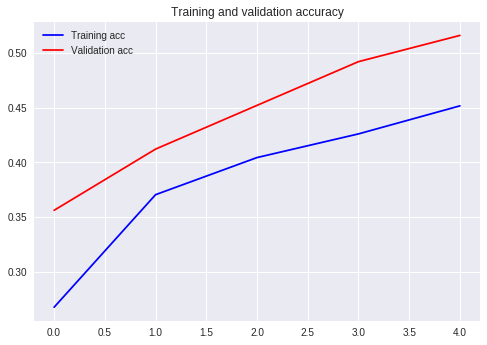

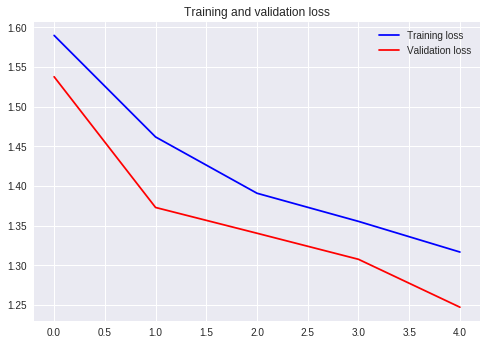

In [46]:
import matplotlib.pyplot as plt
# visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**2nd Model**

In [0]:
model = Sequential()

# layer 1
model.add(Conv2D(128, (3, 3), padding='same',
input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

# layer 2
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# layer 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

# layer 4
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# layer 5
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [49]:
model.compile(loss='categorical_crossentropy',
optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
metrics=['accuracy',metrics.categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_52 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_53 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [50]:
history = model.fit_generator(datagen.flow(x_train, y_train,
    batch_size=100),
    epochs=5,
    steps_per_epoch=200,
    validation_data=(x_test, y_test),
    verbose=1,
    workers=16)

Epoch 1/5
200/200 [==============================] - 19s 96ms/step - loss: 1.6118 - acc: 0.2025 - categorical_accuracy: 0.2025 - val_loss: 1.6086 - val_acc: 0.2000 - val_categorical_accuracy: 0.2000
Epoch 2/5
200/200 [==============================] - 17s 83ms/step - loss: 1.6070 - acc: 0.2205 - categorical_accuracy: 0.2205 - val_loss: 1.6071 - val_acc: 0.2000 - val_categorical_accuracy: 0.2000
Epoch 3/5
200/200 [==============================] - 17s 84ms/step - loss: 1.6047 - acc: 0.2276 - categorical_accuracy: 0.2276 - val_loss: 1.6024 - val_acc: 0.2640 - val_categorical_accuracy: 0.2640
Epoch 4/5
200/200 [==============================] - 17s 85ms/step - loss: 1.5902 - acc: 0.2497 - categorical_accuracy: 0.2497 - val_loss: 1.5767 - val_acc: 0.3080 - val_categorical_accuracy: 0.3080
Epoch 5/5
200/200 [==============================] - 17s 85ms/step - loss: 1.5465 - acc: 0.2929 - categorical_accuracy: 0.2929 - val_loss: 1.5301 - val_acc: 0.3120 - val_categorical_accuracy: 0.3120


In [51]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 400us/step
Test loss: 1.530141918182373
Test accuracy: 0.3120000004768372


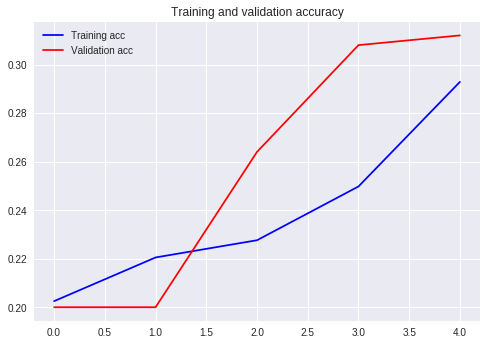

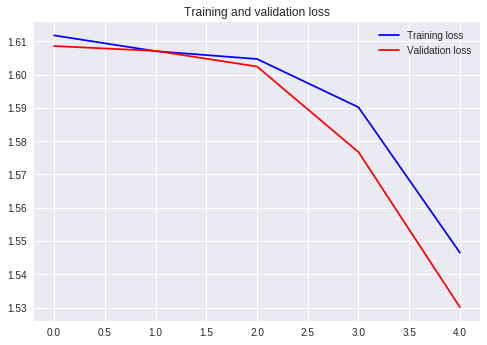

In [52]:
# visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**3rd Model**

In [53]:
from keras.layers.convolutional import Convolution2D

model = Sequential()
#conv-spatial batch norm - relu #1 
model.add(ZeroPadding2D((2,2),input_shape=x_train.shape[1:]))
model.add(Convolution2D(64,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu')) 

#conv-spatial batch norm - relu #2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64,3,3,subsample=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu')) 

#conv-spatial batch norm - relu #3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128,3,3,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.25)) 

#conv-spatial batch norm - relu #4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128,3,3,subsample=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu')) 

#conv-spatial batch norm - relu #5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256,3,3,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu')) 

#conv-spatial batch norm - relu #6
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256,3,3,subsample=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.25))

#conv-spatial batch norm - relu #7
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512,3,3,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu')) 

#conv-spatial batch norm - relu #8
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512,3,3,subsample=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu')) 


#conv-spatial batch norm - relu #9
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(1024,3,3,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25)) 

#Affine-spatial batch norm -relu #10 
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), strides=(1, 1))`
/usr

In [54]:
model.compile(loss='categorical_crossentropy',
optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
metrics=['accuracy',metrics.categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_15 (ZeroPaddi (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_60 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 16, 64)        256       
__________

In [55]:
history = model.fit_generator(datagen.flow(x_train, y_train,
    batch_size=100),
    epochs=5,
    steps_per_epoch=200,
    validation_data=(x_test, y_test),
    verbose=1,
    workers=16)

Epoch 1/5
200/200 [==============================] - 25s 124ms/step - loss: 1.5854 - acc: 0.3863 - categorical_accuracy: 0.3863 - val_loss: 1.4415 - val_acc: 0.4560 - val_categorical_accuracy: 0.4560
Epoch 2/5
200/200 [==============================] - 20s 102ms/step - loss: 1.1886 - acc: 0.5346 - categorical_accuracy: 0.5346 - val_loss: 1.2386 - val_acc: 0.5360 - val_categorical_accuracy: 0.5360
Epoch 3/5
200/200 [==============================] - 20s 102ms/step - loss: 0.9997 - acc: 0.6139 - categorical_accuracy: 0.6139 - val_loss: 1.2326 - val_acc: 0.5720 - val_categorical_accuracy: 0.5720
Epoch 4/5
200/200 [==============================] - 20s 102ms/step - loss: 0.8830 - acc: 0.6534 - categorical_accuracy: 0.6534 - val_loss: 1.0571 - val_acc: 0.6160 - val_categorical_accuracy: 0.6160
Epoch 5/5
200/200 [==============================] - 20s 102ms/step - loss: 0.7880 - acc: 0.6924 - categorical_accuracy: 0.6924 - val_loss: 1.0478 - val_acc: 0.6160 - val_categorical_accuracy: 0.6160


In [56]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 395us/step
Test loss: 1.0478313913345336
Test accuracy: 0.6159999995231629


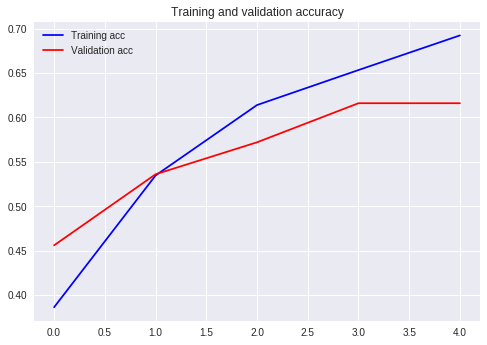

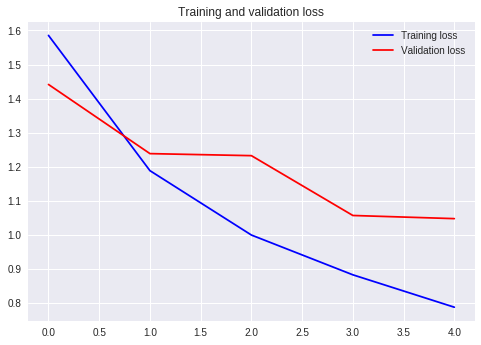

In [57]:
# visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**4th Model(Best one)**

In [0]:
model = Sequential()

# """Block 1"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', 
					input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))

# """Block 2"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# """Block 3"""
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# """Block 4"""
model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# """Block 5"""
model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# """Block Test"""
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

# """Output Layer"""
model.add(Dense(num_classes))

# """Loss Layer"""
model.add(Activation('softmax'))

In [59]:
model.compile(loss='categorical_crossentropy',
optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
metrics=['accuracy',metrics.categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_53 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
activation_71 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 128)       147584    
__________

In [60]:
history = model.fit_generator(datagen.flow(x_train, y_train,
    batch_size=100),
    epochs=5,
    steps_per_epoch=200,
    validation_data=(x_test, y_test),
    verbose=1,
    workers=16)

Epoch 1/5
200/200 [==============================] - 29s 144ms/step - loss: 0.7578 - acc: 0.7116 - categorical_accuracy: 0.7116 - val_loss: 0.8821 - val_acc: 0.6840 - val_categorical_accuracy: 0.6840
Epoch 2/5
200/200 [==============================] - 24s 120ms/step - loss: 0.3438 - acc: 0.8830 - categorical_accuracy: 0.8830 - val_loss: 0.7034 - val_acc: 0.7360 - val_categorical_accuracy: 0.7360
Epoch 3/5
200/200 [==============================] - 24s 120ms/step - loss: 0.2018 - acc: 0.9397 - categorical_accuracy: 0.9397 - val_loss: 0.7150 - val_acc: 0.7880 - val_categorical_accuracy: 0.7880
Epoch 4/5
200/200 [==============================] - 24s 120ms/step - loss: 0.1250 - acc: 0.9676 - categorical_accuracy: 0.9676 - val_loss: 0.7247 - val_acc: 0.7720 - val_categorical_accuracy: 0.7720
Epoch 5/5
200/200 [==============================] - 24s 120ms/step - loss: 0.0820 - acc: 0.9821 - categorical_accuracy: 0.9821 - val_loss: 0.7239 - val_acc: 0.7720 - val_categorical_accuracy: 0.7720


In [61]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 516us/step
Test loss: 0.7238801364898682
Test accuracy: 0.7719999985694885


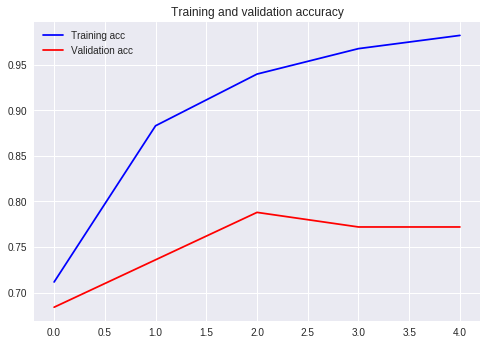

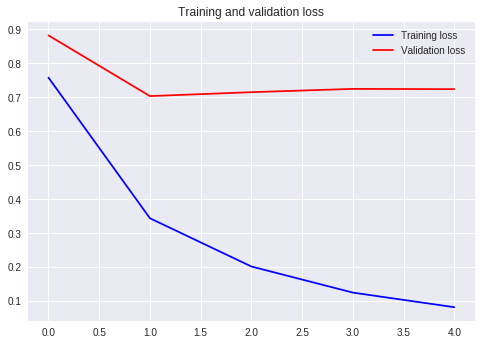

In [62]:
# visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**5th Model**

In [0]:
model = Sequential()


model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', 
					input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))


model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


model.add(Conv2D(512, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


model.add(Conv2D(1024, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1024, (3, 3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [64]:
model.compile(loss='categorical_crossentropy',
optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
metrics=['accuracy',metrics.categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_63 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_64 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
activation_78 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 256)       295168    
__________

In [65]:
history = model.fit_generator(datagen.flow(x_train, y_train,
    batch_size=100),
    epochs=5,
    steps_per_epoch=200,
    validation_data=(x_test, y_test),
    verbose=1,
    workers=16)

Epoch 1/5
200/200 [==============================] - 54s 270ms/step - loss: 0.6671 - acc: 0.7487 - categorical_accuracy: 0.7487 - val_loss: 0.8590 - val_acc: 0.7160 - val_categorical_accuracy: 0.7160
Epoch 2/5
200/200 [==============================] - 48s 241ms/step - loss: 0.2391 - acc: 0.9273 - categorical_accuracy: 0.9273 - val_loss: 0.7460 - val_acc: 0.7360 - val_categorical_accuracy: 0.7360
Epoch 3/5
200/200 [==============================] - 48s 240ms/step - loss: 0.1137 - acc: 0.9710 - categorical_accuracy: 0.9710 - val_loss: 0.7655 - val_acc: 0.7400 - val_categorical_accuracy: 0.7400
Epoch 4/5
200/200 [==============================] - 48s 240ms/step - loss: 0.0599 - acc: 0.9888 - categorical_accuracy: 0.9888 - val_loss: 0.8144 - val_acc: 0.7440 - val_categorical_accuracy: 0.7440
Epoch 5/5
200/200 [==============================] - 48s 240ms/step - loss: 0.0363 - acc: 0.9945 - categorical_accuracy: 0.9945 - val_loss: 0.8980 - val_acc: 0.7520 - val_categorical_accuracy: 0.7520


In [66]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 1ms/step
Test loss: 0.8980336780548096
Test accuracy: 0.7520000019073486


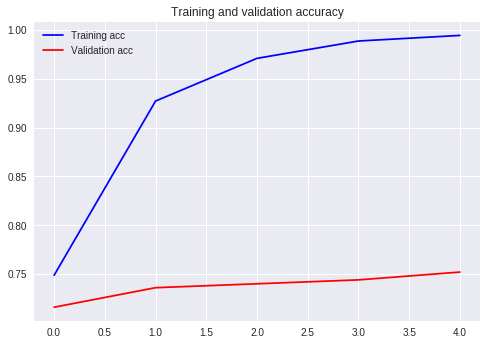

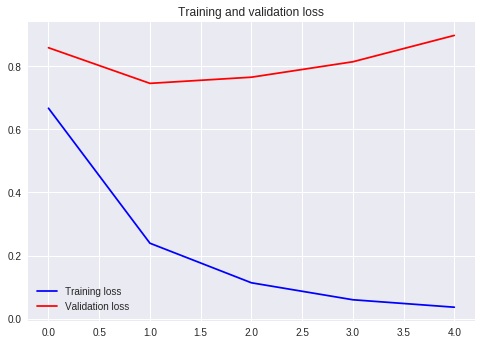

In [67]:
# visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()